# Día 5: Práctica - SARIMA y Transición a Aprendizaje Supervisado

En este notebook cubriremos:
1. Carga o generación de un dataset con estacionalidad.
2. Ajuste de un modelo ARIMA y uno SARIMA, comparando resultados.
3. Breve introducción a la generación de features (lag, variables de calendario) para un modelo supervisado.


In [10]:
# Sección 0: Importaciones

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# statsmodels para SARIMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

%matplotlib inline
sns.set_style("whitegrid")


## Sección 1: Carga / Creación de Datos con Estacionalidad

Si tienes un dataset real (p.ej. ventas mensuales durante varios años), cárgalo con `pd.read_csv(...)`.
Para la demostración, generaremos datos sintéticos con una clara estacionalidad mensual.


In [11]:
# Generación de datos sintéticos (ejemplo mensual)

np.random.seed(42)
date_range = pd.date_range(start='2022-01', end='2024-12', freq='M')
n = len(date_range)

# Tendencia suave
trend = np.linspace(100, 200, n)

# Estacionalidad (12 meses)
seasonality = 20 * np.sin(2 * np.pi * np.arange(n) / 12)

# Ruido
noise = np.random.normal(0, 5, n)

values = trend + seasonality + noise

df = pd.DataFrame({'consumo': values}, index=date_range)
df.head()


/tmp/ipykernel_31980/2160930351.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start='2022-01', end='2024-12', freq='M')


,consumo
2022-01-31,102.483571
2022-02-28,112.249855
2022-03-31,126.441304
2022-04-30,136.438679
2022-05-31,127.914447


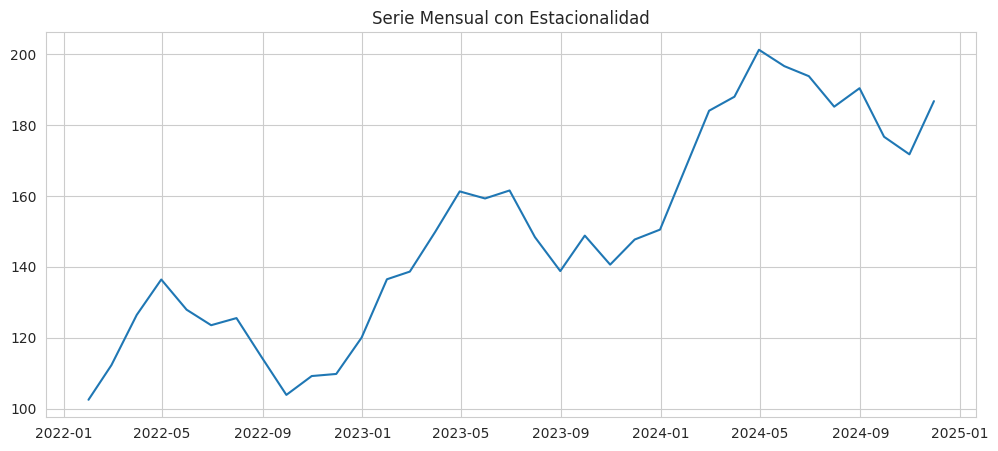

In [12]:
# Visualización
plt.figure(figsize=(12,5))
plt.plot(df.index, df['consumo'], label='Consumo')
plt.title('Serie Mensual con Estacionalidad')
plt.show()


Observamos la ondulación estacional (~período 12 meses).

---
## Sección 2: Ajuste de ARIMA básico (sin estacionalidad explícita)


In [13]:
# Dividimos en train y test (80% - 20%)
split = int(len(df)*0.8)
train = df.iloc[:split]
test = df.iloc[split:]

# Ajuste de un ARIMA(p,d,q) con statsmodels (ejemplo p=1,d=1,q=1)
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(train['consumo'], order=(1,1,1))
results_arima = model_arima.fit()
print(results_arima.summary())

# Pronóstico
forecast_arima = results_arima.forecast(steps=len(test))


                               SARIMAX Results                                
Dep. Variable:                consumo   No. Observations:                   28
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -98.026
Date:                Fri, 31 Jan 2025   AIC                            202.052
Time:                        18:05:09   BIC                            205.939
Sample:                    01-31-2022   HQIC                           203.208
                         - 04-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6372      0.448      1.423      0.155      -0.241       1.515
ma.L1         -0.2899      0.571     -0.507      0.612      -1.410       0.830
sigma2        82.7568     38.593      2.144      0.0

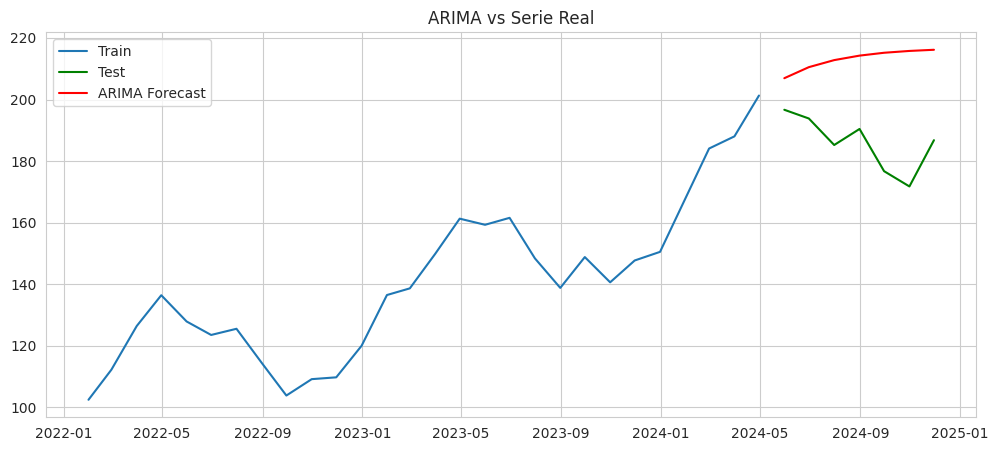

In [14]:
# Gráfico comparativo
plt.figure(figsize=(12,5))
plt.plot(train.index, train['consumo'], label='Train')
plt.plot(test.index, test['consumo'], label='Test', color='g')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast', color='r')
plt.title("ARIMA vs Serie Real")
plt.legend()
plt.show()


Observa cómo un ARIMA simple puede que no capture bien la **estacionalidad**.

---
## Sección 3: Ajuste de SARIMA


In [15]:
# Ajustamos un SARIMA(p,d,q)(P,D,Q,m)
# Asumimos estacionalidad mensual con m=12
# p.ej: (1,1,1)(1,1,1,12)

model_sarima = SARIMAX(train['consumo'],
                       order=(1,1,1),
                       seasonal_order=(1,1,1,12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
results_sarima = model_sarima.fit()
print(results_sarima.summary())

# Pronóstico
forecast_sarima = results_sarima.forecast(steps=len(test))


/home/caumel/anaconda3/envs/time_series_course/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                            consumo   No. Observations:                   28
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   3.047
Date:                            Fri, 31 Jan 2025   AIC                              3.907
Time:                                    18:05:10   BIC                             -6.093
Sample:                                01-31-2022   HQIC                              -inf
                                     - 04-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4067      3e-05  -1.35e+04      0.000      -0.407      -0.407
ma.L1          0.4806   3.76e-06   

/home/caumel/anaconda3/envs/time_series_course/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/caumel/anaconda3/envs/time_series_course/lib/python3.10/site-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning: divide by zero encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/home/caumel/anaconda3/envs/time_series_course/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


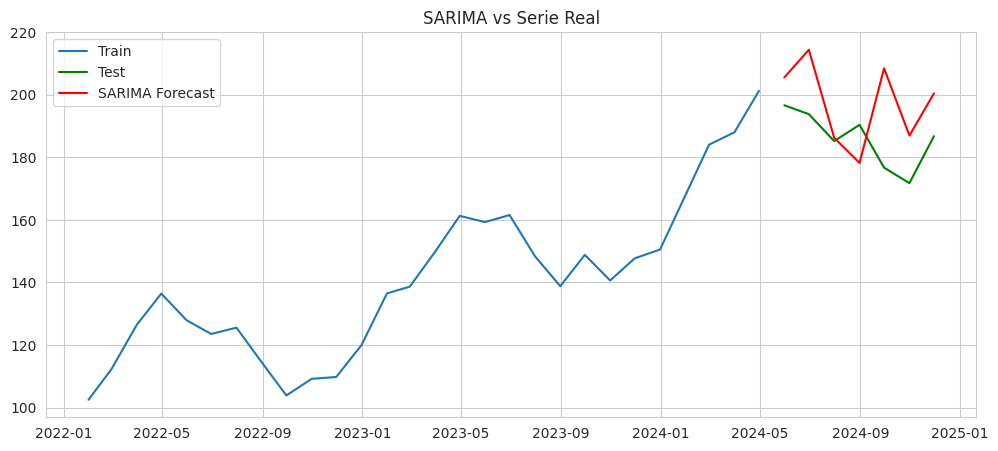

In [16]:
# Gráfico comparativo
plt.figure(figsize=(12,5))
plt.plot(train.index, train['consumo'], label='Train')
plt.plot(test.index, test['consumo'], label='Test', color='g')
plt.plot(test.index, forecast_sarima, label='SARIMA Forecast', color='r')
plt.title("SARIMA vs Serie Real")
plt.legend()
plt.show()


Podremos apreciar una mejora en la captura de los picos y valles estacionales. 

---
## Sección 4: Comparación de Resultados

Revisemos alguna métrica de error (MSE, MAE):


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_arima = mean_squared_error(test['consumo'], forecast_arima)
mae_arima = mean_absolute_error(test['consumo'], forecast_arima)

mse_sarima = mean_squared_error(test['consumo'], forecast_sarima)
mae_sarima = mean_absolute_error(test['consumo'], forecast_sarima)

print(f"ARIMA - MSE: {mse_arima:.2f}, MAE: {mae_arima:.2f}")
print(f"SARIMA - MSE: {mse_sarima:.2f}, MAE: {mae_sarima:.2f}")


ARIMA - MSE: 855.51, MAE: 27.16
SARIMA - MSE: 297.32, MAE: 14.77


Esperamos que SARIMA tenga un error más bajo si la estacionalidad es fuerte.

---
## Sección 5: Preparación de Datos para un Modelo Supervisado

*Nota*: Aquí solo haremos una introducción. Más adelante profundizaremos.

### 5.1. Creando características (Feature Engineering)

Por ejemplo, generamos:
1. **Lags**: `consumo(t-1)`, `consumo(t-2)`, etc.
2. **Variables de calendario**: mes, estacionalidad en una variable categórica, etc.


In [18]:
df_supervised = df.copy()

# Lags
df_supervised['lag1'] = df_supervised['consumo'].shift(1)
df_supervised['lag2'] = df_supervised['consumo'].shift(2)

# Variable de mes (para capturar estacionalidad)
df_supervised['mes'] = df_supervised.index.month

df_supervised.dropna(inplace=True)
df_supervised.head()


,consumo,lag1,lag2,mes
2022-03-31,126.441304,112.249855,102.483571,3
2022-04-30,136.438679,126.441304,112.249855,4
2022-05-31,127.914447,136.438679,126.441304,5
2022-06-30,123.535198,127.914447,136.438679,6
2022-07-31,125.543123,123.535198,127.914447,7


**Observamos**: Ahora tenemos varias columnas que podrían servir como predictores para un modelo supervisado (ej. regresión lineal, random forest).

---
## Sección 6: Tarea

1. **Ajustar y comparar** diferentes órdenes de SARIMA en tu dataset (explora `p, d, q, P, D, Q, m`).  
2. **Agregar** variables exógenas si tu dataset real las tiene (ej. clima, día festivo, etc.) usando SARIMAX.  
3. **Generar** un conjunto de features para un posterior modelo supervisado (por ejemplo, un *RandomForestRegressor*).  
4. **Documentar** los resultados y conclusiones.

¡Eso es todo!
